# 介紹

本教程介紹了使用TensorFlow實現簡單線性模型的workflow。在加載MNISIT（手寫字符圖像數據集）後，我們使用TensorFlow定義並優化一個簡單的數學模型。然後繪製並討論結果。

This tutorial demonstrates the basic workflow of using TensorFlow with a simple linear model. After loading the so-called MNIST data-set with images of hand-written digits, we define and optimize a simple mathematical model in TensorFlow. The results are then plotted and discussed.

In [258]:
# 為了在 Jupyter Notebook中使用 matplotlib.pyplot的 plot函数，實現內嵌繪畫，需要加上 %matplotlib inline，並且可以省略掉 plt.show()
%matplotlib inline  
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import numpy as np
from sklearn.metrics import confusion_matrix
# check 一下 tensorflow 的版本
tf.__version__

'2.0.0'

In [259]:
# Load Data
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [260]:
print("Size of:")
print(f"- Training-set:\t\t{len(data.train.labels)}")
print(f"- Test-set:\t\t{len(data.test.labels)}")
print(f"- Validation-set:\t{len(data.validation.labels)}")

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


MNIST數據集已經加載好，該數據集包含70,000幅圖像和標籤（即圖像的類別）。數據集被分成3個互不交叉的子集（訓練集、測試集和驗證集），在本教程中，我們將只使用訓練集和測試集。

## 獨熱編碼（One-Hot Encoding）

MNIST數據集由One-hot encoding方式加載。這意味著標籤由單個數字（類別）轉換成一個向量，其長度等價於可能類別數量（如有10類，則長度為10）。向量的所有元素除了第i個元素為 1之外（因為該標籤的類別是i），其它元素都為0。

The data-set has been loaded as so-called One-Hot encoding. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $ i$'th element which is one and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the test-set are

In [261]:
# 輸出前5個標籤的向量數據
data.test.labels[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

我們還需要將類（classes）作為單個數字進行各種比較和性能測量，因此我們通過獲取最高元素（其值為1）的索引來將One-Hot編碼向量轉換為單個數字。請注意，'class'這個詞是Python中使用的關鍵字，因此我們需要使用名稱'cls'。

We also need the classes as single numbers for various comparisons and performance measures, so we convert the One-Hot encoded vectors to a single number by taking the index of the highest element. Note that the word 'class' is a keyword used in Python so we need to use the name 'cls' instead.

In [262]:
# argmax(): 回傳 array 裡最大值的位置
data.test.cls = np.array([label.argmax() for label in data.test.labels])
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

In [263]:
# MNIST圖像數據的每個像素是 28 即 28x28
img_size = 28

# 圖像存在一維數據中
img_size_flat = img_size * img_size

# 將圖像的高度和寬度存成不可變的 tuple，用來 reshape arrays
img_shape = (img_size, img_size)

# 類別的數量：10，即每一類用一個數值来表示
num_classes = 10

## 數據維度（Data dimensions）

數據維度會在下面的代碼中被使用。在計算機編程中，最好使用使用變量（variables）和常量（constants），而不是每次使用該編號時候都必須對特定數字進行硬編碼（hard-code）。這意味著數字只需要在一個地方被修改。理想情況下，這些數據可以從已經讀取的數據中推斷（inferred）出來，但在這裡我們只是寫出數字。


## 常用的常數向量建構函數
除了使用 tf.constant() 創造常數張量以外，常用的建構函數有：

    tf.zeros() ：建構內容數值皆為 0 的常數張量
    tf.ones() ：建構內容數值皆為 1 的常數張量
    tf.fill() ：建構內容數值皆為特定值的常數張量
    tf.range() ：建構內容數值為 (start, limit, delta) 數列的常數張量
    tf.random_normal() ：建構內容數值為符合常態分佈數列的常數張量
    tf.random_uniform() ：建構內容數值為符合均勻分佈數列的常數張量
    
## 變數
雖然以常數進行數值運算很方便，但就如同在程式設計中不可能永遠只倚賴值（Values）一般，常見的情況是為了保持彈性，必須將值宣告賦值給變數（Variables）讓使用者能夠動態地進行相同的計算來得到不同的結果，這在 TensorFlow 中是以 tf.Variable() 來完成，就像是在 Python 中簡單宣告變數一般。

不過在 TensorFlow 的觀念之中，宣告變數張量並不如 Python 或者先前宣告常數張量那麼單純，它需要兩個步驟：

----
1. 宣告變數張量的初始值、類型與外觀
2. 初始化變數張量
----

該如何初始化變數張量呢？只需將變數張量的 initializer 屬性放入 Session 中執行即可。

    #Pythonic
    lucky_number = 24
    print("Pythonic:")
    print(lucky_number)

    #TensorFlow
    lucky_number = tf.Variable(24, name = "lucky_number")
    print("TensorFlow:")
    with tf.Session() as sess:
    sess.run(lucky_number.initializer)
    print(sess.run(lucky_number))


## 常用的矩陣建構與計算函數
TensorFlow 的二維張量與 NumPy 的二維陣列相同為矩陣提供了各種方便使用者呼叫的建構、運算函數，而矩陣亦是 NumPy 與TensorFlow 應用實務中最常被使用的類型，而常用的矩陣建構與計算函數有：

    tf.reshape() ：調整矩陣外觀
    tf.eye() ：建構單位矩陣
    tf.diag() ：建構對角矩陣
    tf.matrix_transpose() ：轉置矩陣
    tf.matmul() ：矩陣相乘

In [264]:

def plot_images(images, cls_true, cls_pred=None):
    # 判斷輸入參數是否符合要求
    assert len(images) == len(cls_true) == 9
    
    # create 3x3 的圖和 subplots 的集合
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 畫圖
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # 顯示預測和類別
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # 删除 plot的刻度（ticks）
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

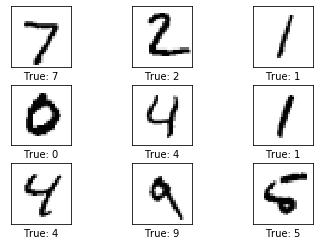

In [265]:
# 從測試集中取得前9幅圖像數據
images = data.test.images[0:9]

# 取得相對應的類別
cls_true = data.test.cls[0:9]

# 使用上述函數繪製圖像和標籤（非預測）
plot_images(images=images, cls_true=cls_true)

## 佔位符變量（Placeholder variables）

佔位符變量（Placeholder variables）作為圖的輸入，我們可以在每次執行圖的時候進行更改。我們稱之為 餵（feeding）佔位符變量，並在下面進一步說明。

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

首先，我們定義輸入圖像的佔位符變量‘x’。這允許我們改變輸入到TensorFlow圖的圖像。這是一個所謂的張量（tensor），這意味著它是一個多維向量或矩陣。該佔位符的數據類型設置成'float32'，形狀設置成'[None, img_size_flat]'，其中'None'表示張量可以存儲（hold）任意數量的圖像，每個圖像是長度為'img_size_flat'的向量。

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data -type is set to float32 and the shape is set to [None, img_size_flat], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.

# 總結：
1. Placeholder 是 Tensorflow 中的佔位符，暫時儲存變量.
2. Tensorflow 如果想要從外部傳入data, 那就需要用到 tf.placeholder(), 然後以這種形式傳輸數據 sess.run()
3. 函式定義如下：tf.placeholder(dtype, shape=None, name=None)
4. dtype：資料型別。常用的是tf.float32,tf.float64等數值型別。
5. shape：資料形狀。預設是None，就是一維值。如果是多維的話，定義如下:[2,3], [None, 3]等。其中 [None, 3]表示列是3，行數不定。此引數可以根據提供的資料推導得到，不一定要給出。
6. name：變數名稱

In [266]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

接下來，我們定義佔位符變量‘y_true’，其是存放與占位符‘x’中輸入圖像相關聯的真實標籤。該佔位符變量的數據類型設置成'float32'，形狀是'[None, num_classes]'，這意味著它可以包含任意數量的標籤，每個標籤是長度為'num_classes'的向量，在這種情況下為10。

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [267]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

最後，我們定義佔位符變量‘y_true_cls’，其實存放與占位符‘x’中輸入圖像相關的類別。該佔位符的數據類型設置成‘int64’，形狀設置為‘[None]’，這意味著該佔位符變量是任意長度的一維向量。

Finally we have the placeholder variable for the true class of each image in the placeholder variable x. These are integers and the dimensionality of this placeholder variable is set to [None] which means the placeholder variable is a one-dimensional vector of arbitrary length.

In [268]:
y_true_cls = tf.placeholder(tf.int64, [None])

待優化的變量（Variables to be optimized）
除了上面定義用作將輸入數據輸入到模型中的佔位符變量之外，還有一些模型變量必須由TensorFlow進行更改，以使模型在訓練數據上表現更好。

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.

必須優化的第一個變量稱為“權重（weights）”，在這裡定義為TensorFlow變量，必須用零初始化，形狀為[img_size_flat，num_classes]，因此它是具有img_size_flat行和num_classes列的二維張量（或矩陣） 。

The first variable that must be optimized is called weights and is defined here as a TensorFlow variable that must be initialized with zeros and whose shape is [img_size_flat, num_classes], so it is a 2-dimensional tensor (or matrix) with img_size_flat rows and num_classes columns.

In [269]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

第二個必須要優化的變量稱為“偏置（biases)”，其實長度為‘num_classes’的一維度張量（或向量）。這裡也初始化為零。

The second variable that must be optimized is called biases and is defined as a 1-dimensional tensor (or vector) of length num_classes.

In [270]:
biases = tf.Variable(tf.zeros([num_classes]))

## 模型（Model）
簡單的數學模型是將佔位符變量‘x’乘以權重‘weights’，並加上偏置‘biases’

This simple mathematical model multiplies the images in the placeholder variable x with the weights and then adds the biases.

根據矩陣性質，輸出結果是形狀為‘[num_images, num_classes]’的矩陣。因為'x'的形狀為'[num_images, img_size_flat]'，'weights'的形狀為'[img_size_flat, num_classes]'，所以這兩個矩陣相乘的結果是形狀為'[num_images, num_classes]'的矩陣。然後將‘biases’向量加到矩陣的每一行上（利用廣播的特性）。

The result is a matrix of shape [num_images, num_classes] because x has shape [num_images, img_size_flat] and weights has shape [img_size_flat, num_classes], so the multiplication of those two matrices is a matrix with shape [num_images, num_classes] and then the biases vector is added to each row of that matrix.

注意：名稱‘logits’是典型的TensorFlow術語（terminogy），但你也可以叫做其它變量。

Note that the name logits is typical TensorFlow terminology, but other people may call the variable something else

In [271]:
logits = tf.matmul(x, weights) + biases

現在logits是一個帶有num_images行和num_classes列的矩陣，其中第 i 行和第 j 列的元素是對第 i 幅輸入圖像估計為第 j 類的可能性（概率值）。

Now logits is a matrix with num_images rows and num_classes columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $ j$'th class.

然而，這些估計是大概的（rough）值且難以解釋，因為這些數字可能非常小或很大，所以我們想對它們進行歸一化處理，以使logits矩陣的每一行總和為1（因為概率值和為1)，並且每個元素被限制在[0,1]。這是使用所謂的softmax函數（又稱歸一化指數函數）計算的，結果存儲在y_pred中。

However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the logits matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in y_pred.

注：附上Softmax相關資源

[Softmax function wiki](https://en.wikipedia.org/wiki/Softmax_function)

[Softmax 函數的特點和作用是什麼？](https://www.getit01.com/p2017112512302/)

[Softmax回歸](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E4%BD%BF%E7%94%A8-tensorflow-%E5%AD%B8%E7%BF%92-softmax-%E5%9B%9E%E6%AD%B8-softmax-regression-41a12b619f04)

In [272]:
y_pred = tf.nn.softmax(logits)

可以通過獲取 y_pred矩陣中每行中最大元素的索引計算預測的類別 y_pred_cls。

The predicted class can be calculated from the y_pred matrix by taking the index of the largest element in each row.

In [273]:
y_pred_cls = tf.argmax(y_pred, axis=1)

## 待優化的代價函數（Cost-function to be optimized）

為了使模型更好地分類輸入圖像，我們必須以某種方式改變“權重”（weights）和“偏差”（biases）的變量。要做到這一點，首先我們需要通過將模型的預測輸出“y_pred”與期望輸出“y_true”進行比較來了解模型當前的表現如何。

To make the model better at classifying the input images, we must somehow change the variables for weights and biases. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true .

交叉熵（cross-entropy）是用於分類的性能度量。交叉熵是一個連續的函數，它總是正的，如果模型的預測輸出與期望的輸出完全匹配，則交叉熵等於零。因此，優化的目標是盡量減少交叉熵，即通過改變模型的“權重”和“偏差”來使得交叉熵盡可能地接近於零。

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.

TensorFlow具有用於計算交叉熵的內置函數。請注意，它使用logits的值，因為它也可以在內部計算softmax。

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the logits because it also calculates the softmax internally.

In [274]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)

我們現在已經計算了每個圖像分類的交叉熵，因此我們可以衡量模型在每幅圖像上的測試性能。但為了使用交叉熵來指導模型變量的優化，我們需要一個標量值，所以我們簡單地取所有圖像分類的交叉熵的平均值。

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [275]:
# tf.reduce_mean 函數用於計算張量tensor沿著指定的數軸（tensor的某一維度）上的的平均值，主要用作降維或者計算 tensor（圖像）的平均值。
cost = tf.reduce_mean(cross_entropy)

## 優化方法（Optimization method）
現在我們有一個必須要最小化的代價度量（交叉熵），然後我們可以創建一個優化器（optimizer）。在這種情況下，我們採用 tf的梯度下降優化器，其步長設置為0.5。

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.5.

注意：此處不執行優化。事實上，包括上述的操作，其實並沒有進行運算，我們只是將待優化的對象添加到TensorFlow圖中以便以後執行。

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [276]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

衡量指標（Performance measures）
我們需要更多的衡量指標來向用戶顯示進度。

無論預測的類別是否等於每個圖像的真實類別，這都是布爾值（boolean）。

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [277]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

這通過首先將布爾值的類型轉換為浮點數來計算分類準確度，令False為0，True為1，然後計算這些數字的平均值。

注：使用 tf.cast 將數據類型進行變換

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [278]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 運行TensorFlow（TensorFlow Run）

創建TensorFlow會話（Create TensorFlow session）
一旦創建好TensorFlow圖（graph），我們還需要創建一個用於執行圖的TensorFlow會話。

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [279]:
session = tf.Session()

初始化變量（Initialize variables）
變量 weights 和 biases必須在開始優化前進行初始化。

注：一般採用 **tf.global_variables_initializer()** 對所有變量進行初始化。

The variables for weights and biases must be initialized before we start optimizing them.

In [280]:
session.run(tf.global_variables_initializer())

執行迭代優化的幫助函數（Helper-function to perform optimization iterations）
訓練集含有50,000 幅圖像。使用所有這些圖像來計算模型的梯度耗時較久。因此，我們使用隨機梯度下降法（Stochastic Gradient Descent，SGD），它只在優化器的每次迭代中使用一小批（small batch）圖像。

There are 50.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

**小結：用一部分的資料來計算，目的是為了省時**

In [281]:
batch_size = 100

用於執行若干次優化迭代的函數，以逐漸改善模型的“權重”和“偏差”。在每次迭代中，從訓練集中選擇一批新的數據，然後TensorFlow使用這些訓練樣本執行優化器。

Function for performing a number of optimization iterations so as to gradually improve the weights and biases of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [282]:
def optimize(num_iterations):
    """優化器"""
    for i in range(num_iterations):
        # 取得一小批訓練樣本
        # x_batch 存一小批訓練樣本，y_true_batch是這些訓練樣本的（圖）之真實標籤
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # 將批處理(batch)放入合適命名的字典中，該字典中的 key 是TensorFlow 圖中的占位符變量（x、y_true和 y_true_cls）。
        # 注意：占位符 y_true_cls 並不是集合（set），因為在訓練時，没有被使用
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        # 使用小批量的訓練數據來運行優化器
        # 在 feed_dict_train中，TensorFlow 將變量賦值给占位符變量，然後運行優化器
        session.run(optimizer, feed_dict = feed_dict_train)

顯示的幫助函數（Helper-functions to show performance）
使用測試集數據（10,000幅圖像）進行Dict，以用作TensorFlow圖的輸入。請注意，我們必須在TensorFlow圖中使用佔位符變量的正確名稱。

Dict with the test-set data to be used as input to the TensorFlow graph. Note that we must use the correct names for the placeholder variables in the TensorFlow graph.

In [283]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

輸出測試集上分類準確率的函數

Function for printing the classification accuracy on the test-set

In [284]:
def print_accuracy():
    """計算與輸出準確率"""
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuray on test-set: {0:.1%}".format(acc))

使用scikit-learn 輸出並繪製 誤差（confusion）矩陣的函數

Function for printing and plotting the confusion matrix using scikit-learn.

In [285]:
def print_confusion_matrix():
    '''輸出誤差矩陣'''
    # 取得真實測試集的分類標籤
    cls_true = data.test.cls
    
    # 計算測試集的預測分類结果
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # 使用 sklearn 計算誤差矩陣，confusion_matrix 是 sklearn的 API 函数
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    print(cm)
    
    # 繪製誤差矩陣  
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # 調整繪圖
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [286]:
def plot_example_errors():
    '''畫出錯誤分類的樣本'''
    # 使用 TensorFlow 取得布尔值列表，無論每個測試圖像是否已正確分類
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
 
    # 錯誤的 Boolean 涵數
    incorrect = (correct == False)
    
    # 從測試集中獲取已被錯誤分類的圖像數據
    images = data.test.images[incorrect]
    
    # 獲得這些圖像的預測類別
    cls_pred = cls_pred[incorrect]

    # 獲得這些圖像的真實類別
    cls_true = data.test.cls[incorrect]
    
    # 繪製前 9 幅圖像（錯誤分類的）
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

繪製模型權重的幫助函數（Helper-function to plot the model weights）¶
用於繪製模型權重的函數。繪製10幅圖像，每幅圖像對應於被模型訓練識別的類別。

Function for plotting the weights of the model. 10 images are plotted, one for each digit that the model is trained to recognize.

In [287]:
def plot_weights():
    '''繪製模型權重'''
    # 從 TensorFlow 變量中獲取權重的值
    w = session.run(weights)
    
    # 計算權重的最小值和最大值
    # 用于校正圖像間的顏色强度，以便它们可以相互比較
    w_min = np.min(w)  # 權重的最小值
    w_max = np.max(w)  # 權重的最大值

    # 創建含 3x4子圖的圖像，其中最後兩個無意義。
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # 取得第 i 幅圖像的權重，並改變其形狀與圖像數據一致
            # 注意：w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # 為子圖設置標籤(label)
            ax.set_xlabel("Weights: {0}".format(i))

           
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        # 删除每個子圖的刻度
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

優化前的性能（Performance before any optimization）
測試集的準確度為9.8％。這是因為該模型只進行了初始化而沒有進行優化，因此它總是預測圖像顯示為零數字（預測類別為零），如下圖所示。

print_accuray()表示在會話中執行圖，即發生了“真正”的運算。

The accuracy on the test-set is 9.8%. This is because the model has only been initialized and not optimized at all, so it always predicts that the image shows a zero digit, as demonstrated in the plot below, and it turns out that 9.8% of the images in the test-set happens to be zero digits.

Accuray on test-set: 9.8%


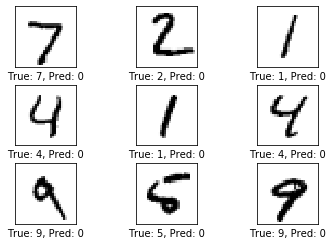

In [288]:
# 輸出測試級的準確率
print_accuracy()
# 繪製錯誤的樣本
plot_example_errors()

## 在 10 次迭代優化後的性能（Performance after 1 optimization iteration

經過一次優化迭代後，該模型已將測試集的準確度從 9.8％ 提高約 70％ 這意味著它在10次中有 7 次對圖像進行了錯誤分類，如下面的幾個例子所示。

Already after a single optimization iteration, the model has increased its accuracy on the test-set to 40.7% up from 9.8%. This means that it mis-classifies the images about 6 out of 10 times, as demonstrated on a few examples below.

Accuray on test-set: 71.2%


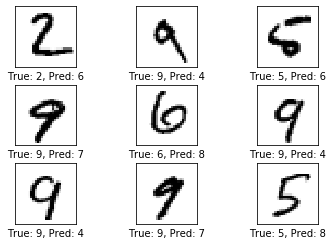

In [289]:
optimize(num_iterations=10)
print_accuracy()
plot_example_errors()

## 在迭代1000次優化後的性能（Performance after 1000 optimization iterations）

在1000次迭代優化後，模型僅對大約十分之一的圖像進行錯誤分類（即正確率在90%左右）。如下所示，一些誤分類是合理的，因為即使對於人類來說，圖像也很難確定，而其他圖像非常明顯，應該通過一個好的模型正確分類。但是這種簡單的模型無法達到更好的性能，因此需要更複雜的模型。

After 1000 optimization iterations, the model only mis-classifies about one in ten images. As demonstrated below, some of the mis-classifications are justified because the images are very hard to determine with certainty even for humans, while others are quite obvious and should have been classified correctly by a good model. But this simple model cannot reach much better performance and more complex models are therefore needed.

Accuray on test-set: 91.5%


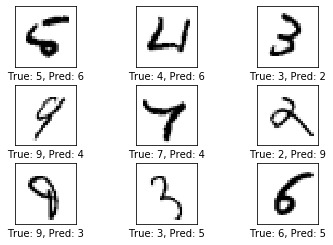

In [290]:
optimize(num_iterations=1000)
print_accuracy()
plot_example_errors()

該模型現已經過1000次迭代優化的訓練，每次迭代使用來自訓練集的100幅圖像。由於圖像種類繁多，權重現在變得難以解釋，我們可能會懷疑模型是否真正了解數字是如何由線條組成的，或者模型是否只記住了許多不同的像素變體。

注：迭代越多次，可視化的權重變得越難以解釋。

The model has now been trained for 1000 optimization iterations, with each iteration using 100 images from the training-set. Because of the great variety of the images, the weights have now become difficult to interpret and we may doubt whether the model truly understands how digits are composed from lines, or whether the model has just memorized many different variations of pixels.

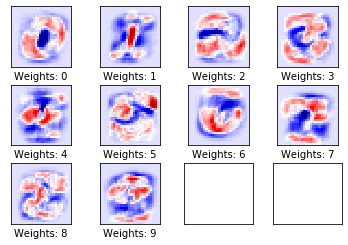

In [291]:
plot_weights()

我們還可以印出和繪製所謂的誤差矩陣（confusion matrix），讓我們可以看到有關錯誤分類的更多細節。例如，它顯示實際描述 5的圖像有時被錯誤分類為所有其它可能的數字，但大多數是3, 6或 8。

We can also print and plot the so-called confusion matrix which lets us see more details about the mis-classifications. For example, it shows that images actually depicting a 5 have sometimes been mis-classified as all other possible digits, but mostly either 3, 6 or 8.

[[ 957    0    2    2    0    7   10    1    1    0]
 [   0 1109    2    2    0    3    4    1   14    0]
 [   5    6  937   15   10    7   16    9   21    6]
 [   3    0   22  892    0   66    2   10    7    8]
 [   1    2    4    2  916    2   16    2    7   30]
 [   8    4    4   17    7  818   12    3   14    5]
 [  14    3    3    2    9   22  903    1    1    0]
 [   3    8   26    9    8    2    0  940    1   31]
 [   8   10   13   40    8   78   13   13  785    6]
 [  10    8    2   10   41   18    0   22    3  895]]


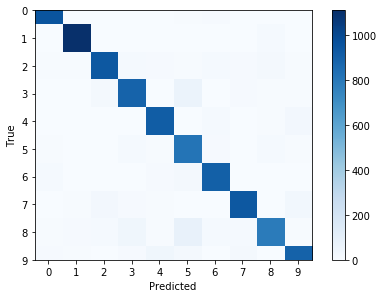

In [292]:
print_confusion_matrix()

上圖分別顯示了誤差矩陣的文本形式和圖像形式。其中文本形式可以看到誤分類的具體情況，如真實為5的圖像被預測為5的情況最多（預測正確），大概在700+ ，其次被預測為3和8的情況也比較多。而圖像可視化，可以較為直觀地看出當前模型的分類準確情況。深藍色表示多數圖像被預測的結果分佈，由上圖可知： 預測結果和真實情況出入不大，模型的正確率還可以。

最後，我們通過關閉會話（Session）來釋放內存資源。

We are now done using TensorFlow, so we close the session to release its resources.

In [293]:
session.close()

# 練習（Exercises）

下面是一些可能有助於提高TensorFlow技能的練習建議。獲得TensorFlow的實踐經驗對於學習如何正確使用它非常重要。

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

進行任何更改之前，您可能需要備份此文件。

1. 更改優化器的學習率（learning rate）。
2. 將優化器更改為 AdagradOptimizer或 AdamOptimizer。
3. 將批量大小更改為 1或 1000。
4. 思考上述這些變化如何影響性能？
5. 您是否認為這些變化對其他分類問題和數學模型具有相同的影響（如果有的話）？
6. 如果多次運行本文件，而不更改任何參數，您會得到完全相同的結果嗎？為什麼或者為什麼不？
7. 更改函數plot_example_errors()，以便它還打印錯誤分類示例的logits和y_pred值。
8. 使用sparse_softmax_cross_entropy_with_logits而不是softmax_cross_entropy_with_logits。這可能需要對源代碼中的多個位置進行多處更改。討論使用這兩種方法的優缺點。
9. 自己重新編寫程序，而不必過多考慮此源代碼。
10. 解釋程序是如何工作的。